In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
# 设置随机种子
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [3]:
# 加载 MNIST 数据集
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 选择较小的尺寸
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 过滤出 0 和 7
data_0 = [img for img, label in mnist_data if label == 0]
data_7 = [img for img, label in mnist_data if label == 7]

print(f"Number of digit 0 images extracted: {len(data_0)}, digit 7 images extracted: {len(data_7)}")

Number of digit 0 images extracted: 5923, digit 7 images extracted: 6265


In [4]:
# 生成均匀分布的 0 的 fraction 列表并打乱
num_bags = 500
num_instances = 100  # 每个 bag 100 张图像
frac_0_list = np.linspace(0, 1, num_bags)
np.random.shuffle(frac_0_list)  # 打乱 fraction 顺序，确保随机

# 训练集/测试集划分，保证 fraction 分布均匀
train_frac_0, test_frac_0 = train_test_split(frac_0_list, test_size=0.2, random_state=42)

# 定义 MILMNIST 数据集类
class MILMNISTDataset(Dataset):
    def __init__(self, data_0, data_7, num_instances, frac_0_list):
        self.num_instances = num_instances
        self.bags = []
        self.labels = []

        for frac_0 in frac_0_list:
            num_0 = int(frac_0 * num_instances)
            num_7 = num_instances - num_0

            # **使用 random.sample 进行无放回采样，避免重复**
            bag_0 = random.sample(data_0, min(num_0, len(data_0)))
            bag_7 = random.sample(data_7, min(num_7, len(data_7)))

            bag = bag_0 + bag_7
            random.shuffle(bag)

            self.bags.append(torch.stack(bag))  # (100, 3, 64, 64)
            self.labels.append(frac_0)

    def __len__(self):
        return len(self.bags)
    
    def __getitem__(self, idx):
        return self.bags[idx], torch.tensor(self.labels[idx], dtype=torch.float32)

# 创建训练集和测试集
train_dataset = MILMNISTDataset(data_0, data_7, num_instances, train_frac_0)
test_dataset = MILMNISTDataset(data_0, data_7, num_instances, test_frac_0)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

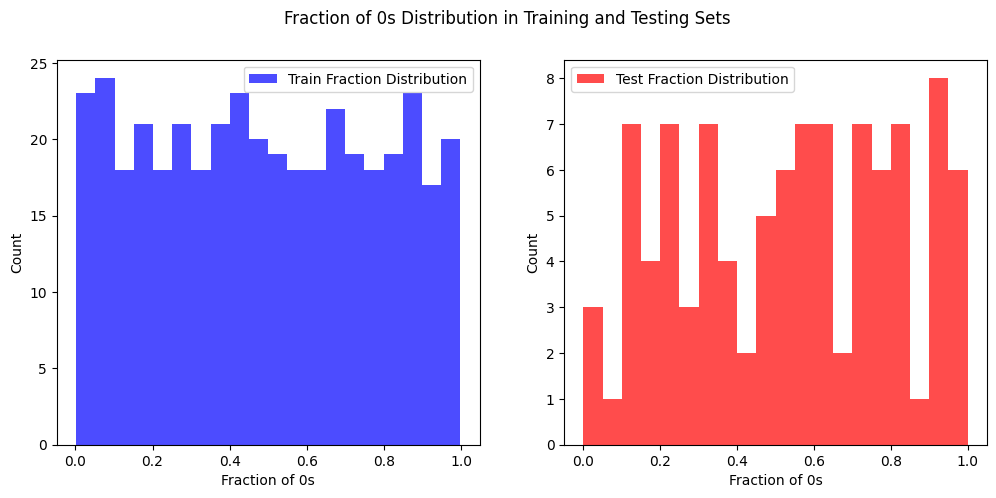

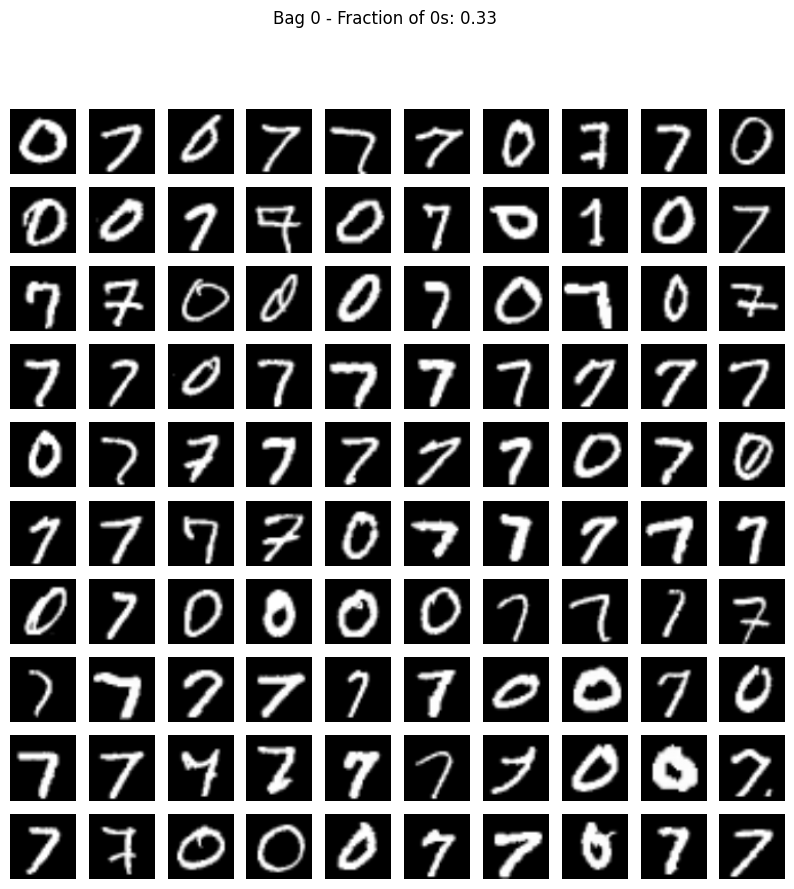

In [5]:
# 可视化 fraction 分布
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_frac_0, bins=20, color='blue', alpha=0.7, label='Train Fraction Distribution')
plt.xlabel('Fraction of 0s')
plt.ylabel('Count')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(test_frac_0, bins=20, color='red', alpha=0.7, label='Test Fraction Distribution')
plt.xlabel('Fraction of 0s')
plt.ylabel('Count')
plt.legend()

plt.suptitle("Fraction of 0s Distribution in Training and Testing Sets")
plt.show()

# 定义可视化构造的 bags 的方法
def visualize_bag(dataset, bag_idx=0):
    bag, label = dataset[bag_idx]
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    fig.suptitle(f"Bag {bag_idx} - Fraction of 0s: {label:.2f}")
    
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(bag[i][0].numpy(), cmap='gray')
        ax.axis('off')
    
    plt.show()

# 可视化一个训练集中的 bag
visualize_bag(train_dataset, bag_idx=0)

In [6]:
# 定义模型
class MILResNet(nn.Module):
    def __init__(self):
        super(MILResNet, self).__init__()

        # 1. 加载 ResNet18 作为特征提取器
        self.resnet = models.resnet18(pretrained=True)

        # 2. 修改最后一个全连接层，使输出变成 128 维
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 128)
        
        # 3. Pooling 层（Mean Pooling）
        self.pooling = nn.AdaptiveAvgPool1d(1)  # 平均池化 (N, 128, num_instances) -> (N, 128, 1)

        # 4. MLP 回归层
        self.mlp = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 384),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(384, 192),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(192, 1)  # 输出 1 维（回归）
        )

    def forward(self, x):
        batch_size, num_instances, _, _, _ = x.shape  # (B, N, C, H, W)
        
        # 1. Reshape 输入为 (batch_size * num_instances, 1, 224, 224)
        x = x.view(batch_size * num_instances, 3, 64, 64)

        # 2. 送入 ResNet 提取 128 维特征
        features = self.resnet(x)  # (batch_size * num_instances, 128)

        # 3. 重新 reshape: (batch_size, num_instances, 128)
        features = features.view(batch_size, num_instances, 128).permute(0, 2, 1)  # 变成 (batch_size, 128, num_instances)

        # 4. Mean Pooling: (batch_size, 128, num_instances) -> (batch_size, 128, 1) -> squeeze -> (batch_size, 128)
        pooled_features = self.pooling(features).squeeze(-1)

        # 5. MLP 回归
        output = self.mlp(pooled_features)  # (batch_size, 1)
        
        return output.squeeze(-1)  # 最后输出 (batch_size,)

In [7]:
# 创建模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MILResNet().to(device)

# 超参数
lr = 1e-4
weight_decay = 0.0005
batch_size = 1
num_epochs = 30

# 损失函数 & 优化器
criterion = nn.MSELoss() # L2损失函数
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# 数据加载
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 训练循环
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for bags, labels in train_loader:
        bags, labels = bags.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(bags)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

C:\Users\cwJin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\cwJin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Train Loss: 0.0716
Epoch [2/30], Train Loss: 0.0346
Epoch [3/30], Train Loss: 0.0260
Epoch [4/30], Train Loss: 0.0237
Epoch [5/30], Train Loss: 0.0268
Epoch [6/30], Train Loss: 0.0234
Epoch [7/30], Train Loss: 0.0220
Epoch [8/30], Train Loss: 0.0183
Epoch [9/30], Train Loss: 0.0216
Epoch [10/30], Train Loss: 0.0207
Epoch [11/30], Train Loss: 0.0166
Epoch [12/30], Train Loss: 0.0206
Epoch [13/30], Train Loss: 0.0172
Epoch [14/30], Train Loss: 0.0181
Epoch [15/30], Train Loss: 0.0161
Epoch [16/30], Train Loss: 0.0181
Epoch [17/30], Train Loss: 0.0183
Epoch [18/30], Train Loss: 0.0162
Epoch [19/30], Train Loss: 0.0179
Epoch [20/30], Train Loss: 0.0199
Epoch [21/30], Train Loss: 0.0147
Epoch [22/30], Train Loss: 0.0156
Epoch [23/30], Train Loss: 0.0155
Epoch [24/30], Train Loss: 0.0168
Epoch [25/30], Train Loss: 0.0158
Epoch [26/30], Train Loss: 0.0155
Epoch [27/30], Train Loss: 0.0131
Epoch [28/30], Train Loss: 0.0139
Epoch [29/30], Train Loss: 0.0128
Epoch [30/30], Train Lo

In [8]:
# 评估
model.eval()
test_loss = 0.0
with torch.no_grad():
    for bags, labels in test_loader:
        bags, labels = bags.to(device), labels.to(device)
        outputs = model(bags)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0244


R² Score: 0.6862
MSE: 0.0244, RMSE: 0.1563


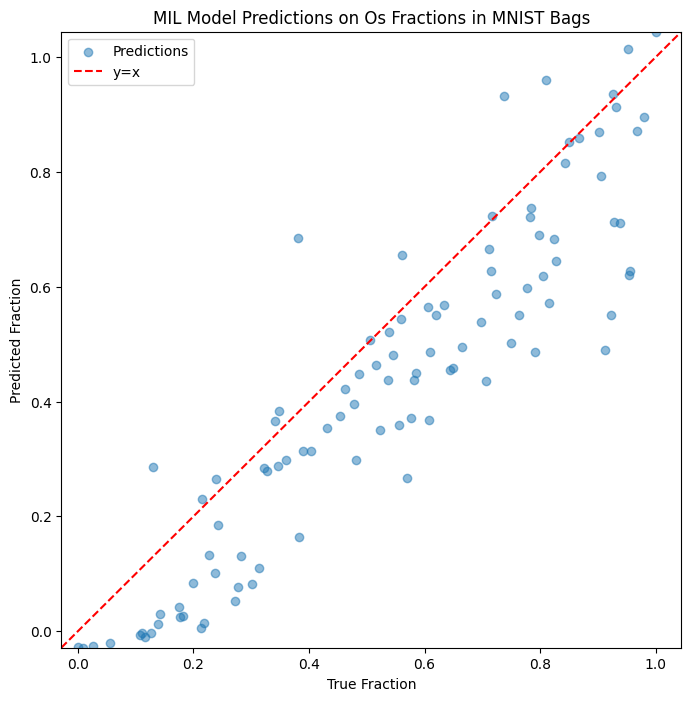

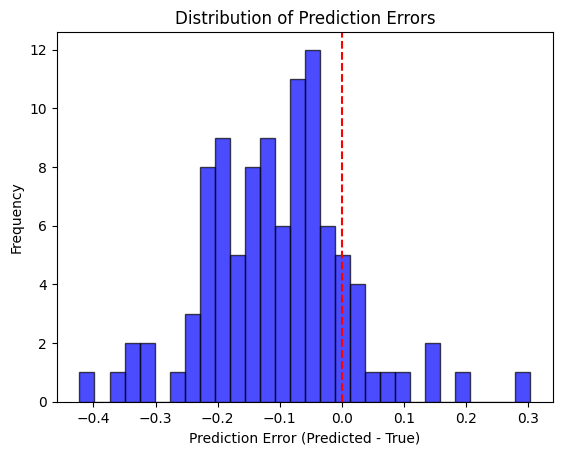

In [9]:
model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for bags, labels in test_loader:
        bags = bags.to(device)
        outputs = model(bags).cpu().numpy()
        preds.extend(outputs)
        true_labels.extend(labels.numpy())

# 计算 R² 等分数
r2 = r2_score(true_labels, preds)
mse = mean_squared_error(true_labels, preds)
rmse = np.sqrt(mse)
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}")

# 可视化预测结果
min_val = min(min(true_labels), min(preds))
max_val = max(max(true_labels), max(preds))

plt.figure(figsize=(8, 8))
plt.scatter(true_labels, preds, alpha=0.5, label="Predictions")
plt.xlabel("True Fraction")
plt.ylabel("Predicted Fraction")
plt.title("MIL Model Predictions on Os Fractions in MNIST Bags")
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="y=x")
plt.legend()
plt.show()

# 可视化误差分布
errors = np.array(preds) - np.array(true_labels)  # 计算误差

plt.hist(errors, bins=30, alpha=0.7, color="blue", edgecolor="black")
plt.axvline(x=0, color='red', linestyle="--")  # 标记误差为0的位置
plt.xlabel("Prediction Error (Predicted - True)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()